<a href="https://colab.research.google.com/github/Tim-Li/X-ray_summer_school_2022/blob/main/code/Python%E5%AF%A6%E4%BD%9C_Day1%EF%BC%9APython%E5%9C%A8%E4%B8%89%E7%B6%ADX%E5%85%89%E5%BD%B1%E5%83%8F%E9%87%8D%E5%BB%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python實作 Day1：Python在三維X光影像重建

# 一、操作說明

## Python基礎操作

### 查看當前python版本

In [ ]:
!python --version

Python 3.7.13


### 第一支 Python 程式

In [ ]:
print('hello world')

hello world


In [ ]:
# print('hello world')

## 3D X光影像重建流程(需要畫圖)

## 實做流程(需要畫圖)

# 二、python實作：3D X-ray CT影像重建

## 環境建置

### 1.開啟Colab上GPU(需要圖)

編輯 -> 筆記本設定

硬體加速器 -> 點選GPU -> 儲存

### 2.安裝python函式庫

安裝condacolab (run time: 約40s)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:47
🔁 Restarting kernel...


安裝tomography相關套件 (run time: 約200s)

In [ ]:
!git clone https://github.com/ahendriksen/noise2inverse.git root_dir

Cloning into 'root_dir'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 96 (delta 29), reused 90 (delta 23), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
!mamba env update -n base -f root_dir/environment.yml
!pip install -e root_dir/.
!pip install matplotlib==3.1.3
!cp -r root_dir/noise2inverse '/usr/local/lib/python3.7/site-packages'
!pip install gdown

pkgs/main/linux-64       [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pkgs/r/linux-64          [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pkgs/r/linux-64          [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noarch         [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pkgs/r/linux-64          [] (00m:00s) 21 KB / ?? (142.42 KB/s)
pytorch/noarch           [] (--:--) Finalizing...
pkgs/main/linux-64       [] (00m:00s) 21 KB / ?? (142.34 KB/s)
pkgs/main/noar

安裝3D viewer套件(itkwidgets)

In [ ]:
import sys

!{sys.executable} -m pip install -q --upgrade --pre itk-io
!{sys.executable} -m pip install -q dask toolz scikit-image matplotlib "itkwidgets>=1.0a6"
!pip install pyyaml==5.4.1
!pip install pillow===8.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 10.2 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0


清除暫存安裝檔

In [ ]:
import shutil
shutil.rmtree('root_dir')

### 3.載入python函式庫

python基礎套件

In [ ]:
import numpy as np
from pathlib import Path
import gdown
import glob
import time

影像處理

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import tifffile
from noise2inverse import tiffs, tomo
import tomosipo as ts
import tomopy
from skimage.transform import iradon
import foam_ct_phantom

ipython互動介面

In [ ]:
%matplotlib inline
from ipywidgets import interact

itkwidgets 3D-viewer套件

In [ ]:
from urllib.request import urlretrieve
import os
import zipfile
import itk
import dask.array.image
from itkwidgets import view

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.


### 4.建立運作資料夾(連接到Google雲端)

連接 Google 雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




*   選擇帳戶
*   允許



創建資料夾(day_1:tomography)

In [ ]:
project_dir = Path("day_1:tomography")
project_dir.mkdir(exist_ok=True)

## 3D X-ray 影像重建

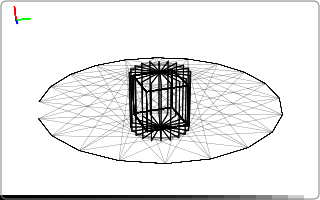

In [ ]:
pg = ts.cone(angles=20, size=np.sqrt(2), cone_angle=0.5)
vg = ts.volume()
ts.svg(pg, vg)

### 1.下載資料集(X光影像)

In [ ]:
%cd $project_dir
url = "https://drive.google.com/uc?id=1JKjh5JGYuZuPexVnibEHequpg2lqTXUI&export=download"
output = "temp.zip"
gdown.download(url, output)
!unzip temp.zip
!rm temp.zip
%cd ..

/content/day_1:tomography


Downloading...
From: https://drive.google.com/uc?id=1JKjh5JGYuZuPexVnibEHequpg2lqTXUI&export=download
To: /content/day_1:tomography/temp.zip
100%|██████████| 2.15M/2.15M [00:00<00:00, 168MB/s]

Archive:  temp.zip
   creating: Input_dataset_128/
  inflating: Input_dataset_128/input_00000.tif  
  inflating: Input_dataset_128/input_00001.tif  
  inflating: Input_dataset_128/input_00002.tif  
  inflating: Input_dataset_128/input_00003.tif  
  inflating: Input_dataset_128/input_00004.tif  
  inflating: Input_dataset_128/input_00005.tif  
  inflating: Input_dataset_128/input_00006.tif  
  inflating: Input_dataset_128/input_00007.tif  
  inflating: Input_dataset_128/input_00008.tif  
  inflating: Input_dataset_128/input_00009.tif  
  inflating: Input_dataset_128/input_00010.tif  
  inflating: Input_dataset_128/input_00011.tif  
  inflating: Input_dataset_128/input_00012.tif  
  inflating: Input_dataset_128/input_00013.tif  
  inflating: Input_dataset_128/input_00014.tif  
  inflating: Input_dataset_128/input_00015.tif  
  inflating: Input_dataset_128/input_00016.tif  
  inflating: Input_dataset_128/input_00017.tif  
  inflating: Input_dataset_128/input_00018.tif  
  inflating: Input

/content


### 2.匯入資料集

In [ ]:
image_stack=[]
for filename in sorted(glob.glob(str(project_dir/'Input_dataset_128'/"input_*.tif"))):
  image = tifffile.imread(filename)
  image_stack.append(image)
print(len(image_stack))

181


瀏覽0~180的影像

In [ ]:
def browse_images(image_stack):
    n = len(image_stack)
    def view_image(angle):
        plt.imshow(image_stack[angle], cmap="gray", interpolation='nearest')
        plt.title('Angle: %s' % angle)
        plt.show()
    interact(view_image, angle=(0,n-1))
browse_images(image_stack)

interactive(children=(IntSlider(value=90, description='angle', max=180), Output()), _dom_classes=('widget-inte…

### 3.sinogram轉換

In [ ]:
sino = tiffs.load_sino(tiffs.glob(project_dir/'Input_dataset_128'))
print(' to ',len(sino),'sinograms')

181it [00:00, 2238.99it/s]

 to  128 sinograms


瀏覽上到下0~127層的sinogram

In [ ]:
def browse_images(sino):
    n = len(sino)
    def view_image(layer):
        plt.imshow(sino[layer], cmap="gray", interpolation='nearest')
        plt.title('layer: %s' % layer)
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(sino)

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

### 4.FBP：Filtered Backward Projection 

創建輸出資料夾

In [ ]:
output_dir = Path(project_dir/"reconstructions")
output_dir.mkdir(exist_ok=True)

重建參數設定

In [ ]:
start_angle, end_angle = 0, 180
angles_s = len(image_stack)
height_s, width_s = image_stack[0].shape

開始重建 

In [ ]:
start = time.perf_counter()
sinogram = np.zeros((angles_s,width_s), np.uint8)
for j in range(height_s):
    sinogram_T = sino[j].T
    theta = np.linspace(start_angle, end_angle, angles_s, endpoint=True)    
    fbp = iradon(sinogram_T, theta=theta, filter_name='ramp',preserve_range=True)*20
    img_save = Image.fromarray(fbp)
    if img_save.mode == "F":
        save = img_save.convert('L')     
    save.save(output_dir/'output_{}.tif'.format(str(j).zfill(5))) 
end = time.perf_counter()
print('CPU Done!!')
print('run time: ',round((end-start),2),'s')

CPU Done!!
run time:  5.13 s


GPU加速(可選)

In [ ]:
# GPU加速設定
start = time.perf_counter()
sino_float32 = (sino/255).astype(np.float32)
height, num_angles, width = sino_float32.shape

vol_shape = (height, width, width)
det_shape = (height, width)
angles = np.linspace(0, np.pi, num=num_angles, endpoint=False)
vg = ts.volume(size=vol_shape, pos=0, shape=vol_shape)
pg = ts.parallel(angles=angles, size=det_shape, shape=det_shape)
A = ts.operator(vg, pg)

# 開始重建
rec = tomo.fbp(A, sino_float32)
rec = tomopy.circ_mask(rec, axis=0, ratio=1.0)

# 存檔
# output_GPU_dir = Path(project_dir/"reconstructions_GPU")
# output_GPU_dir.mkdir(exist_ok=True)
# tiffs.save_stack(output_GPU_dir, rec)

end = time.perf_counter()
print('\n')
print('GPU Done!!')
print('run time: ',round((end-start),2),'s')

128it [00:00, 2396.85it/s]



GPU Done!!
run time:  0.47 s


### 5.檢視重建結果

載入重建結果

In [ ]:
output_stack=[]
for filename in sorted(glob.glob(str(output_dir/"output_*.tif"))):
  image = tifffile.imread(filename)
  output_stack.append(image)
print(len(output_stack))

128


瀏覽重建結果

In [ ]:
def browse_images(output_stack):
    n = len(output_stack)
    def view_image(layer):
        plt.imshow(output_stack[layer], cmap="gray", interpolation='nearest')
        plt.title('layer: %s' % layer)
        plt.show()
    interact(view_image, layer=(0,n-1))
browse_images(output_stack)

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

## 3D viewer

將重建結果匯入 3D-viewer

In [ ]:
stack = dask.array.image.imread(str(output_dir/"output_*.tif"))
stack

dask.array<imread, shape=(128, 128, 128), dtype=uint8, chunksize=(1, 128, 128), chunktype=numpy.ndarray>

顯示3D view (需要稍微等待一下)


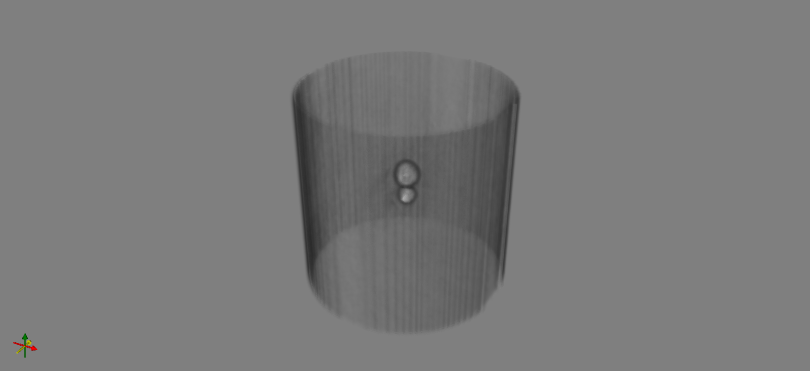
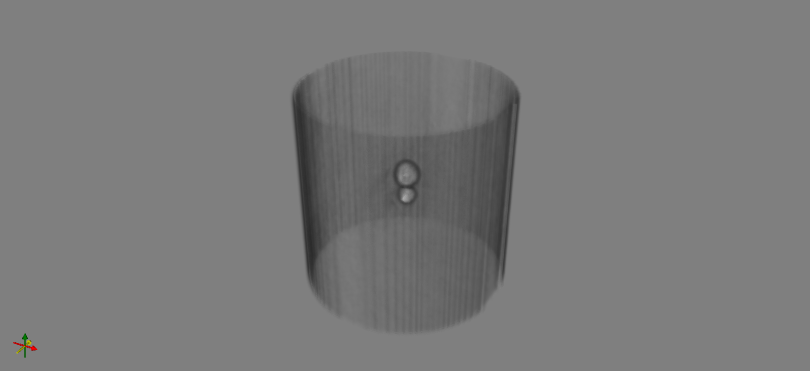

In [ ]:
view(stack, shadow=False, gradient_opacity=0.4, ui_collapsed=True)